<a href="https://colab.research.google.com/github/simi-asher/LLR-perception-assist/blob/master/deep-learning-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade -q gspread
!pip install -q grpcio==1.24.3
!pip install -q google-auth==1.6.3
#!pip install -q tensorflow==2.0.0
!pip install np_utils
import tensorflow as tf
print(tf.__version__)

     |████████████████████████████████| 92kB 5.8MB/s 
ERROR: google-colab 1.0.0 has requirement google-auth~=1.7.2, but you'll have google-auth 1.16.1 which is incompatible.
     |████████████████████████████████| 2.2MB 8.0MB/s 
     |████████████████████████████████| 81kB 4.5MB/s 
ERROR: gspread 3.6.0 has requirement google-auth>=1.12.0, but you'll have google-auth 1.6.3 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.7.2, but you'll have google-auth 1.6.3 which is incompatible.
2.2.0


In [ ]:
!apt-get install swig -y
!pip install Cython numpy
!pip install auto-sklearn

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 32 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 0s (8,794 kB/s)
Selecting previously unselected package swig3.0.
(Reading database ... 144467 files and directories currently installed.)
Preparing to unpack .../swig3.0_3.0.12-1_amd64.deb ...
Unpacking swig3.0 (3.0.12-1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_3.0.12-1_amd64.deb ...
Unpackin

In [ ]:
from numpy.random import seed
seed(1)


In [ ]:
import os
import numpy as np
import pandas as pd
import shutil
import tensorflow as tf
#from tensorflow.contrib import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
#from tensorflow.keras.utils import np_utils
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline


In [ ]:
#read sheets and make dataframes
from google.colab import auth
auth.authenticate_user()

import gspread
import pandas as pd
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

worksheet1 = gc.open('desc_jan_38').sheet1

# get_all_values gives a list of rows.
rows1 = worksheet1.get_all_values()
# Convert to a DataFrame and render.
df1 = pd.DataFrame(rows1)
df1.columns = df1.iloc[0]
df1 = df1.iloc[1:].astype(float)
df1.Unsafe= df1.Unsafe.astype(int)
df1.Safe= df1.Safe.astype(int)
                
print(df1.shape)

worksheet3 = gc.open('desc_feb_38').sheet1

# get_all_values gives a list of rows.
rows3 = worksheet3.get_all_values()
# Convert to a DataFrame and render.
df_feb = pd.DataFrame(rows3)
df_feb.columns = df_feb.iloc[0]
df_feb = df_feb.iloc[1:].astype(float)
df_feb.Unsafe= df_feb.Unsafe.astype(int)
df_feb.Safe= df_feb.Safe.astype(int)
df1=df1.append(df_feb,)                
print(df1.shape)
worksheet2 = gc.open('feb_test_desc_37').sheet1

# get_all_values gives a list of rows.
rows2 = worksheet2.get_all_values()
# Convert to a DataFrame and render.
df2 = pd.DataFrame(rows2)
df2.columns = df2.iloc[0]
df2 = df2.iloc[1:].astype(float)
df2.Unsafe= df2.Unsafe.astype(int)
#df2.Safe= df2.Safe.astype(int)
print(df1.shape,df2.shape)


(13365, 38)
(19626, 38)
(19626, 38) (10022, 37)


In [ ]:
#select K best columns
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler


X1 = df1.iloc[:,0:36].astype(float) # sensor data
Y_train = df1.iloc[:,36:37].astype(int) # labels
X2 = df2.iloc[:,0:36].astype(float) # sensor data
Y_test = df2.iloc[:,36:37].astype(int) # labels

scaler_x = StandardScaler().fit(X1)
X1_scaled = scaler_x.transform(X1)
X2_scaled = scaler_x.transform(X2)

bestfeatures = SelectKBest(score_func=f_classif, k=28) 
fit = bestfeatures.fit(X2_scaled,Y_test) 
cols = bestfeatures.get_support(indices=True)
cols = np.delete(cols, np.argwhere(cols == 0))
cols = np.delete(cols, np.argwhere(cols == 1))
cols = np.delete(cols, np.argwhere(cols == 2))
cols = np.delete(cols, np.argwhere(cols == 3))
cols = np.delete(cols, np.argwhere(cols == 4))
cols = np.delete(cols, np.argwhere(cols == 5))
cols = np.delete(cols, np.argwhere(cols == 6))
cols = np.delete(cols, np.argwhere(cols == 7))
# # cols = np.delete(cols, np.argwhere(cols == 8))
# # cols = np.delete(cols, np.argwhere(cols == 9))
# # cols = np.delete(cols, np.argwhere(cols == 10))
cols = np.delete(cols, np.argwhere(cols == 30))
print(cols,cols.size)
dfscores = pd.DataFrame(fit.scores_) 
dfcolumns = pd.DataFrame(X2.columns) 


#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1) 
featureScores.columns = ['Specs','Score'] #naming the dataframe columns 
print(featureScores.nlargest(28,'Score')) #print 10 best features



[ 8 10 12 14 16 18 19 20 22 23 24 25 26 27 28 29 31 32 33 34] 20
                 Specs        Score
0                EMG 1  4599.749438
24           Encoder 2  1462.123516
12              Foot X  1154.733569
20     Upp Thigh vel X  1137.159663
8                Toe X  1110.016306
10              Heel X  1056.589589
18               Hip X  1047.532180
31             Pitch 2   991.139202
34  Height of obstacle   736.841912
14          Foot vel X   603.341175
22                 ZMP   514.598906
26           Encoder 4   457.137412
32                 Yaw   448.368306
27           Encoder 5   317.678860
16          Foot acc X   285.800021
33    Dist to obstacle   207.106392
1                EMG 2   192.013472
23           Encoder 1   151.968089
5                EMG 6   137.937758
6                EMG 7   134.199014
7                EMG 8    92.830149
28           Encoder 6    61.106149
29                Roll    55.282392
4                EMG 5    48.664239
19               Hip Y    44.187925

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [35] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [ ]:
#to balance data/remove some points from dataframe. Currently commented out
l=[]
print(df1.groupby(['Unsafe']).count(),df2.groupby(['Unsafe']).count())
df3=df1
# #for desc
# df4=df2
#for asc
# temp=df2[(df2['Unsafe'] == 0)].iloc[::1]
# l.append(temp)
# l.append(df2[(df2['Unsafe'] == 1)])
# #df3 = df1.drop(df1[(df1['Unsafe'] == 0) & (df1['Toe X'] < 0.15)& (df1['Toe Y'] < 0.1)].index)
# df4 = pd.concat(l, ignore_index=True)
# df4 =df4.drop(df4[(df4['Unsafe'] == 0) & (df4['Toe Y'] < 0)].index)
# #for sit
temp=df2[(df2['Unsafe'] == 1)].iloc[::2]
l.append(temp)
l.append(df2[(df2['Unsafe'] == 0)])
df4 = pd.concat(l, ignore_index=True)
df4=df4.iloc[::3]

print(df3.groupby(['Unsafe']).count(),df4.groupby(['Unsafe']).count())
X_train = df3.iloc[:,cols]
X_test=df4.iloc[:,cols]
Y_train=df3.iloc[:,36:37]
Y_test=df4.iloc[:,36:37]
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

0       EMG 1  EMG 2  EMG 3  ...  Height of obstacle  Depth of Obstacle   Safe
Unsafe                       ...                                              
0       21475  21475  21475  ...               21475              21475  21475
1       27981  27981  27981  ...               27981              27981  27981

[2 rows x 37 columns] 0       EMG 1  EMG 2  ...  Height of obstacle  Depth of Obstacle
Unsafe                ...                                       
0       36722  36722  ...               36722              36722
1       67677  67677  ...               67677              67677

[2 rows x 36 columns]
0       EMG 1  EMG 2  EMG 3  ...  Height of obstacle  Depth of Obstacle   Safe
Unsafe                       ...                                              
0       21475  21475  21475  ...               21475              21475  21475
1       27981  27981  27981  ...               27981              27981  27981

[2 rows x 37 columns] 0       EMG 1  EMG 2  ...  Height of ob

In [ ]:
#defs for f1 score
from keras import backend as K
import tensorflow as tf
from tensorflow.python.framework import ops

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.clip(y_true * y_pred, 0, 1))
    possible_positives = K.sum(K.clip(y_true, 0, 1))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.clip(y_true * y_pred, 0, 1))
    predicted_positives = K.sum(K.clip(y_pred, 0, 1))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    #y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [ ]:
def create_model():
    # Define model
    global model
    model = Sequential()
    model.add(Dense(15, input_dim=X_train.shape[1], activation='relu',kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    # model.add(Dense(10, activation='relu', kernel_initializer='he_uniform'))
    # model.add(Dropout(0.5))
    # model.add(Dense(15, activation='relu', kernel_initializer='he_uniform'))
    # model.add(Dropout(0.5))
    # model.add(Dense(6, activation='relu', kernel_initializer='he_uniform'))
    # model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    opt = SGD(lr=0.001, momentum=0.9)
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc',f1_loss,f1,tf.keras.metrics.FalsePositives(),tf.keras.metrics.FalseNegatives()])
    return model

In [ ]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        
loss_history = LossHistory()
early_stopping = EarlyStopping('val_loss', patience=5) #prev 20
class_weight = {0:27981/49456, #sit 27981/49456, #desc 9499/19626, #asc comb 9953/20764, #asc jan 6924/15142,
                1:21475/49456 #21475/49456 #10127/19626, #10811/20764 #8218/15142
                }

In [ ]:
#run neural network
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from statistics import mean
import itertools

ops.reset_default_graph()

import keras.backend as K
K.clear_session()

estimator = KerasClassifier(create_model, epochs=70, batch_size=128,shuffle=True)

repeats=30
scores=list()
train_scores=list()
maxim=5000
maxim_acc=0
j=1
for i in range(repeats):
    results = estimator.fit(X_train.values, Y_train.values, callbacks=
        [loss_history,early_stopping], validation_data=(X_test.values, Y_test.values), class_weight=class_weight,verbose=0)
    _,train_acc,train_f1_loss,train_f1,train_fp,train_fn = model.evaluate(X_train, Y_train, verbose=0)
    loss, test_acc,test_f1_loss,test_f1,test_fp,test_fn = model.evaluate(X_test, Y_test, verbose=0)
    if((test_fp+test_fn)<maxim):
      maxim=(test_fp+test_fn)
      maxim_acc=test_acc
      Y_pred=estimator.predict(X_test)
      Y_test_arr=Y_test['Unsafe'].to_numpy()
      print(i,maxim,maxim_acc)
      Y_pred=pd.DataFrame(data=Y_pred)
      Y_pred.columns=['Predicted']
      j=1
      for layer in model.layers:
        if model.layers.index(layer)%2==0: #bc dropout
          #print(model.layers.index(layer),model.layers[model.layers.index(layer)].get_weights())
          w_file="sit_4l_15_ne_"+ str(j)+"w.dat"
          b_file="sit_4l_15_ne_"+ str(j)+"b.dat"
          np.savetxt(os.path.join(w_file), np.transpose(model.layers[model.layers.index(layer)].get_weights()[0]), delimiter='\t',fmt='%+1.6f')
          np.savetxt(os.path.join(b_file), np.transpose(model.layers[model.layers.index(layer)].get_weights()[1]), delimiter='\t',fmt='%+1.6f')
          j+=1

    scores.append(test_acc*100)
    train_scores.append(train_acc*100)
print(scores)
print(mean(train_scores),mean(scores))


0 1362.0 0.9420943260192871
2 909.0 0.9613536596298218
20 388.0 0.9835041165351868
[94.20943260192871, 87.95969486236572, 96.13536596298218, 88.8312578201294, 94.44751739501953, 88.24880123138428, 94.72811818122864, 91.74780249595642, 90.69342017173767, 92.63211488723755, 94.73661780357361, 93.89481544494629, 91.66277050971985, 90.2044951915741, 95.12350559234619, 93.43140125274658, 91.14833474159241, 95.65069675445557, 93.46541166305542, 93.12103986740112, 98.35041165351868, 87.5005304813385, 86.8372917175293, 95.12775540351868, 96.0078239440918, 87.34322786331177, 94.02236342430115, 95.47638297080994, 90.88048934936523, 93.21882724761963]
97.70995120207469 92.56125728289287


In [ ]:
print(Y_pred.head)
np.savetxt(os.path.join("sit_pred.dat"), Y_pred, delimiter='\t',fmt='%+1.6f')

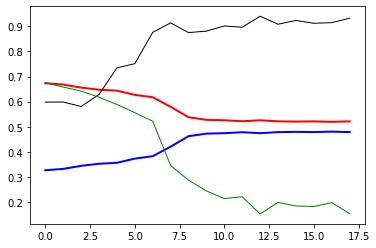

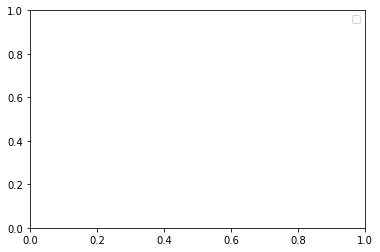

In [ ]:
import matplotlib.pyplot as plt

figsize = (10, 5)
#fig, ax = plt.subplots(figsize=figsize)

plt.plot(results.history['val_f1_loss'], linewidth=2, color="red")
plt.plot(results.history['val_f1'], linewidth=2, color="blue")
plt.plot(results.history['val_acc'], linewidth=1, color="black")
plt.plot(results.history['val_loss'], linewidth=1, color="green")
plt.figure()
plt.legend(['test_loss','test_f1','train_loss','train_f1'])
#plt.set_ylabel('F1 Score')
#plt.set_ylabel('Loss(Categorical Cross Entropy)')
#plt.set_xlabel('Epochs')
plt.show()

49456 23521


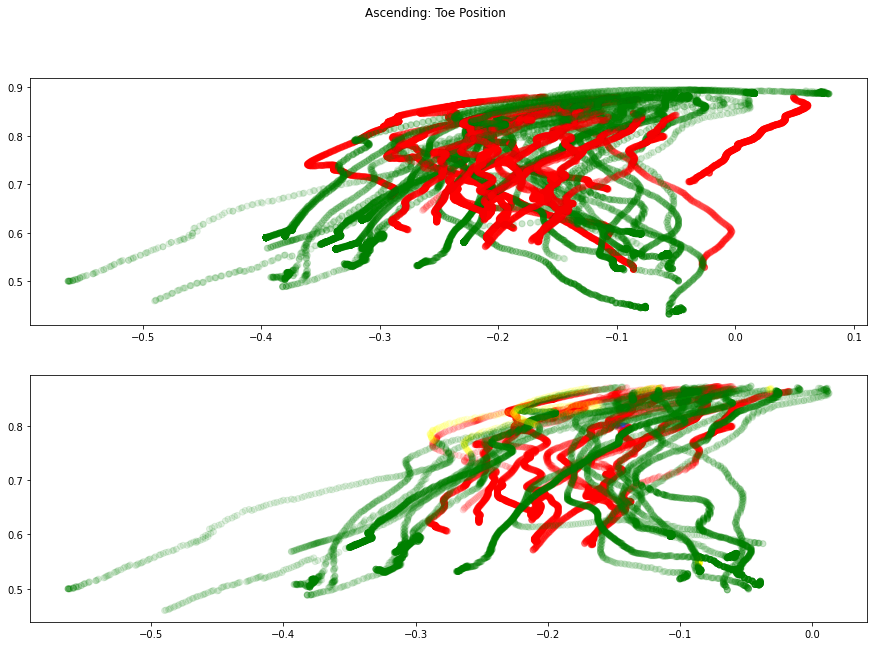

In [ ]:
#plot Toe X&Y train and test points
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

fig, axs = plt.subplots(2,1,figsize=(15,10))
#f=plt.figure(figsize=(12,8))
cols1=['red' if l==1 else 'green' for l in Y_train.Unsafe.values]
cols2=['red' if l==1 else 'green' for l in Y_test.Unsafe.values]
cols2 = np.where((Y_test['Unsafe'].values == 1) & (Y_pred['Predicted'].values== 0),'blue', cols2)
cols2 = np.where((Y_test['Unsafe'].values == 0) & (Y_pred['Predicted'].values== 1),'yellow', cols2)
print(len(cols1),len(cols2))
fig.suptitle('Ascending: Toe Position')
axs[0].scatter(df3['Hip X'], df3['Hip Y'], alpha=0.1,color=cols1)
axs[1].scatter(df4['Hip X'], df4['Hip Y'], alpha=0.1,color=cols2)

#g =sns.scatterplot(x="Dist to obstacle", y="Toe X", hue="Unsafe", data=X_train);
#f =sns.scatterplot(x="Dist to obstacle", y="Toe X",hue="Unsafe",data=X_test)
#f.set_xticks(np.arange(25,60,5)*0.001)

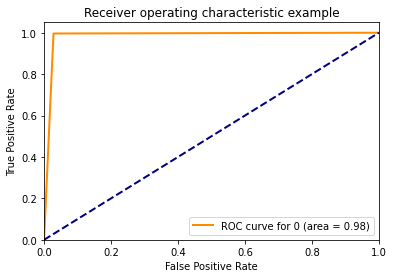

       0      1
0  11896    345
1     43  11237
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     12241
           1       0.97      1.00      0.98     11280

    accuracy                           0.98     23521
   macro avg       0.98      0.98      0.98     23521
weighted avg       0.98      0.98      0.98     23521



In [ ]:
#print confusion matrix and plot ROC curve
cm=confusion_matrix(Y_test_arr, Y_pred)
cm_df = pd.DataFrame(cm)
#print(Y_pred.Predicted)
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(Y_test_arr, Y_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])
#print(fpr[0], tpr[0],fpr[1], tpr[1])
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve for 0 (area = %0.2f)' % roc_auc[0])
#plt.plot(fpr[1], tpr[1], color='red',lw=lw, label='ROC curve for 1 (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

print(cm_df)
print(classification_report(Y_test_arr, Y_pred))

In [ ]:
from google.colab import files
j=1

for layer in model.layers:
        if model.layers.index(layer)%2==0: #bc dropout
            w_file="sit_4l_15_ne_"+ str(j)+"w.dat"
            b_file="sit_4l_15_ne_"+ str(j)+"b.dat"
            print(w_file)
            print(b_file)
            files.download(b_file) 
            files.download(w_file)
            j+=1 

sit_4l_15_ne_1w.dat
sit_4l_15_ne_1b.dat
sit_4l_15_ne_2w.dat
sit_4l_15_ne_2b.dat
sit_4l_15_ne_3w.dat
sit_4l_15_ne_3b.dat


In [ ]:
!pip install tensorflow

In [ ]:
#model.save('NN5_15.h5')
gc = gspread.authorize(GoogleCredentials.get_application_default())
from tensorflow.keras.models import Model
worksheet = gc.open('NN7_kick1').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()
# Convert to a DataFrame and render.
df_test_orig = pd.DataFrame(rows)
df_test_orig.columns = df_test_orig.iloc[0]
print(df_test_orig.columns)
df_test_orig = df_test_orig.iloc[1:].astype(float)
df_test=df_test_orig.iloc[:,cols]
print(df_test.head)
test=df_test.to_numpy()
predicted=model.predict_on_batch(test)
df_test_orig['Fail']=predicted
df_test_orig.to_csv('NN3_kick1.csv')
from google.colab import files
files.download('NN3_kick1.csv')

Index(['EMG 1', 'EMG 2', 'EMG 3', 'EMG 4', 'EMG 5', 'EMG 6', 'EMG 7', 'EMG 8',
       'Toe X', 'Toe Y', 'Heel X', 'Heel Y', 'Foot X', 'Foot Y', 'Foot vel X',
       'Foot vel Y', 'Foot acc X', 'Foot acc Y', 'Hip X', 'Hip Y',
       'Upp Thigh vel X', 'Upp Thigh vel Y', 'ZMP', 'Encoder 1', 'Encoder 2',
       'Encoder 3', 'Encoder 4', 'Encoder 5', 'Encoder 6', 'Roll', 'Pitch 1',
       'Pitch 2', 'Yaw', 'Dist to obstacle', 'Height of obstacle',
       'Depth of Obstacle'],
      dtype='object', name=0)
<bound method NDFrame.head of 0     EMG 2  EMG 3  ...  Height of obstacle  Depth of Obstacle
1     0.420  1.994  ...               0.144               0.22
2     0.420  1.984  ...               0.144               0.22
3     0.420  2.013  ...               0.144               0.22
4     0.415  1.989  ...               0.144               0.22
5     0.415  1.994  ...               0.144               0.22
...     ...    ...  ...                 ...                ...
2709  0.192  0.521  ..

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
print(model.summary())

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_0 (Dense)              (None, 10)                160       
_________________________________________________________________
dropout_0 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.layers[0]._name='dense_0'
model.layers[1]._name='dropout_0'
model.layers[2]._name='dense_1'
print(model.layers[0],model.layers[1],model.layers[2])
print(model.summary())

<tensorflow.python.keras.layers.core.Dense object at 0x7fe364d6d550> <tensorflow.python.keras.layers.core.Dropout object at 0x7fe364d87588> <tensorflow.python.keras.layers.core.Dense object at 0x7fe364d874a8>
Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_0 (Dense)              (None, 10)                160       
_________________________________________________________________
dropout_0 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# 
# from tensorflow.keras.utils import plot_model
# print(Y_pred.head)
# from keras.models import Model

layer_name = 'dense_79'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.(np.reshape(test[0],(1,15)))
print(intermediate_output)

# layer_outputs = [layer.output for layer in model.layers] 
# print(layer_outputs)

[[0.01104912]]


In [ ]:
import tensorflow.keras as keras
session = keras.backend.get_session()
init = tf.global_variables_initializer()
session.run(init)

In [ ]:
from keras import backend as K

# with a Sequential model
get_3rd_layer_output = K.function([model.layers[0].input],
                                  [model.get_layer('dense_0').output])
layer_output = get_3rd_layer_output([np.reshape(test[0],(1,15))])[0]

FailedPreconditionError: ignored

In [ ]:
#logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 
from sklearn import preprocessing
X_train_scaled = preprocessing.scale(X_train)
X_test_scaled = preprocessing.scale(X_test)

print(X_train_scaled.shape,X_test_scaled.shape)
model = LogisticRegression()
model.fit(X_train_scaled, Y_train.values)
Y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(np.asarray(Y_test).flatten(),Y_pred)
print(accuracy)
Y_test_arr=Y_test['Unsafe'].to_numpy()
print(Y_test_arr)
print(Y_pred.flatten())
Y_pred=pd.DataFrame(data=Y_pred)
Y_pred.columns=['Predicted']

(15142, 20) (5304, 20)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6657239819004525
[0 0 0 ... 1 1 1]
[1 1 1 ... 1 1 1]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
#auto-sklearn-not very effective
import autosklearn.classification
import sklearn.metrics
automl = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=120, # run auto-sklearn for at most 2min
          per_run_time_limit=30, # spend at most 30 sec for each model training
          )
automl.fit(X_train.values, Y_train.values)
#automl.cv_results_
print(automl.sprint_statistics())
print(automl.show_models())

y_hat = automl.predict(X_test.values)
test_acc = sklearn.metrics.accuracy_score(Y_test.values, y_hat)
print("Test Accuracy score {0}".format(test_acc))